# Bayesian Neural Networks

Next, we'll look at implementation of Bayesian neural networks using Flux.

In [12]:
using Flux, Turing, Plots, Random, ReverseDiff

Turing.setadbackend(:reversediff);

Generate some data in box shapes.

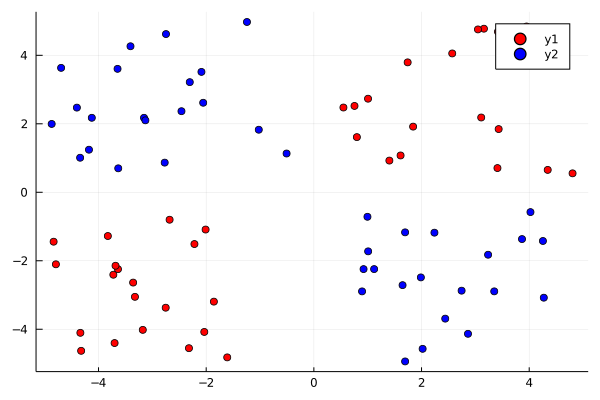

In [13]:
# Number of points to generate.
N = 80
M = round(Int, N / 4)
Random.seed!(1234)

# Generate artificial data.
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
xt1s = Array([[x1s[i] + 0.5; x2s[i] + 0.5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
append!(xt1s, Array([[x1s[i] - 5; x2s[i] - 5] for i = 1:M]))

x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
xt0s = Array([[x1s[i] + 0.5; x2s[i] - 5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
append!(xt0s, Array([[x1s[i] - 5; x2s[i] + 0.5] for i = 1:M]))

# Store all the data for later.
xs = [xt1s; xt0s]
ts = [ones(2*M); zeros(2*M)]

# Plot data points.
function plot_data()
    x1 = map(e -> e[1], xt1s)
    y1 = map(e -> e[2], xt1s)
    x2 = map(e -> e[1], xt0s)
    y2 = map(e -> e[2], xt0s)

    Plots.scatter(x1,y1, color="red", clim = (0,1))
    Plots.scatter!(x2, y2, color="blue", clim = (0,1))
end

plot_data()

Building a feed forward neural network

In [14]:
# Turn vector into a set of weights and biases
function unpack(nn_params::AbstractVector)
    W_1 = reshape(nn_params[1:6], 3, 2);
    b_1 = reshape(nn_params[7:9], 3)
    
    W_2 = reshape(nn_params[10:15], 2, 3);
    b_2 = reshape(nn_params[16:17], 2)
    
    W_0 = reshape(nn_params[18:19], 1, 2);
    b_0 = reshape(nn_params[20:20], 1)
    
    return W_1, b_1, W_2, b_2, W_0, b_0
end

# Construct NN using Flux
function nn_forward(xs, nn_params::AbstractVector)
    W_1, b_1, W_2, b_2, W_0, b_0 = unpack(nn_params)
    nn = Chain(
        Dense(W_1, b_1, tanh),
        Dense(W_2, b_2, tanh),
        Dense(W_0, b_0, σ)
        )
    return nn(xs)
end;

Next, specify the model, including a variable of nn parameters, 20 normally distributed variables (which get assigned in the unpack function.

In [15]:
alpha = 0.09
sig = sqrt(1.0 / alpha)

@model bayes_nn(xs, ts) = begin
    # Weights and biases
    nn_params ~ MvNormal(zeros(20), sig .* ones(20))
    
    # Calculate predictions for inputs
    preds = nn_forward(xs, nn_params)
    
    #observe each prediction
    for i = 1:length(ts)
        ts[i] ~ Bernoulli(preds[i])
    end
end;

Perform inference

In [16]:
N = 5000
ch = sample(bayes_nn(hcat(xs...), ts), HMC(0.05, 4), N);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:56


In [33]:
# Extract all parameters to a variable
theta = Array(group(ch, :nn_params));

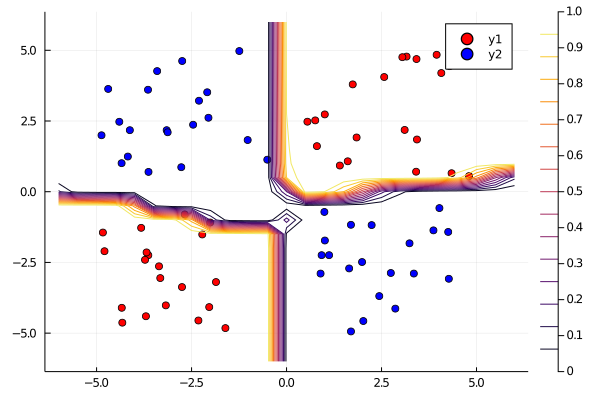

In [34]:
_, i = findmax(ch[:lp])
i = i.I[1]

n_parameters = length(get(ch, :nn_params).nn_params)
theta = [get(ch, :nn_params).nn_params[p][i,1] for p in 1:n_parameters]

x_range = collect(range(-6,stop=6,length=25))
y_range = collect(range(-6,stop=6,length=25))
Z = [nn_forward([x, y], theta)[1] for x=x_range, y=y_range]
contour!(x_range, y_range, Z)

From this, it looks like the MAP approach is not to bad at classification. We can also visualize predictions.